<a href="https://colab.research.google.com/github/MarMarhoun/freelance_work/blob/main/side_projects/NLP_projs/fake_news_detection/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description:

A type of yellow journalism, fake news encapsulates pieces of news that may be hoaxes and is generally spread through social media and other online media. This is often done to further or impose certain ideas and is often achieved with political agendas. Such news items may contain false and/or exaggerated claims, and may end up being viralized by algorithms, and users may end up in a filter bubble.

> Further infos regarding this project can be found [here](https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/).

## Dataset description:

The dataset we’ll use for this python project- we’ll call it news.csv. This dataset has a shape of 7796×4. The first column identifies the news, the second and third are the title and text, and the fourth column has labels denoting whether the news is REAL or FAKE. The dataset takes up 29.2MB of space.

> # Load and preprocess the dataset

In [2]:
# import the necessary libraries

import zipfile
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split


path_to_zip_file = "/content/news.zip"
directory_to_extract_to= "/content/"

data_path = '/content/news.csv'


In [3]:
# Decompress the dataset

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to) 

In [3]:
# Load the Data and take a look at the first samples

df = pd.read_csv(data_path)

df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
print ("Data rows before removing null values",df.shape[0])

Data rows before removing null values 6335


In [ ]:
# check the number of null values per column
print(df.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [ ]:
df.describe()

,Unnamed: 0
count,6335.000000
mean,5280.415627
std,3038.503953
min,2.000000
25%,2674.500000
50%,5271.000000
75%,7901.000000
max,10557.000000


In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

> ### Cleaning and labeling


In [4]:
# replace null values with nan
df.replace('',np.nan,inplace=True)
df.replace(' ',np.nan,inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
# drop nan values in the data
df.dropna(axis=0, how='any', inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6299 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6299 non-null   object
 1   text    6299 non-null   object
 2   label   6299 non-null   object
dtypes: object(3)
memory usage: 196.8+ KB


In [7]:
df = df.astype('string')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6299 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   6299 non-null   string
 1   text    6299 non-null   string
 2   label   6299 non-null   string
dtypes: string(3)
memory usage: 196.8 KB


In [ ]:
print ("Data rows after removing null values",df.shape[0])


Data rows after removing null values 6299


In [6]:
# You can this function here to clean your data

import string
import re

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
# You cen find this function here: https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model#EDA
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+—-', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


In [7]:
# Removing the stop words

from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS


stop_words = list(ENGLISH_STOP_WORDS)
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    


In [ ]:
df.title

0                            You Can Smell Hillary’s Fear
1       Watch The Exact Moment Paul Ryan Committed Pol...
2             Kerry to go to Paris in gesture of sympathy
3       Bernie supporters on Twitter erupt in anger ag...
4        The Battle of New York: Why This Primary Matters
                              ...                        
6330    State Department says it can't find emails fro...
6331    The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332    Anti-Trump Protesters Are Tools of the Oligarc...
6333    In Ethiopia, Obama seeks progress on peace, se...
6334    Jeb Bush Is Suddenly Attacking Trump. Here's W...
Name: title, Length: 6299, dtype: object

In [ ]:
df.columns

Index(['title', 'text', 'label', ('title', 'text')], dtype='object')

In [8]:
## You can use this to clean the data before the splitting phase
cols = ['title', 'text']
for col in cols:
  df[col] = df[col].apply(clean_text)
  df[col] = df[col].apply(remove_stopwords)
df.head()


,title,text,label
0,smell hillary’s fear,daniel greenfield shillman journalism fellow f...,FAKE
1,watch exact moment paul ryan committed politic...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry paris gesture sympathy,secretary state john f kerry said monday stop ...,REAL
3,bernie supporters twitter erupt anger dnc trie...,— kaydee king kaydeeking november lesson ton...,FAKE
4,battle new york primary matters,primary day new york frontrunners hillary clin...,REAL


In [9]:
## FAKE : 0
## REAL : 1

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df['label']

0       0
1       0
2       1
3       0
4       1
       ..
6330    1
6331    0
6332    0
6333    1
6334    1
Name: label, Length: 6299, dtype: int64

In [ ]:
df

,title,text,label
0,smell hillary’s fear,daniel greenfield shillman journalism fellow f...,0
1,watch exact moment paul ryan committed politic...,google pinterest digg linkedin reddit stumbleu...,0
2,kerry paris gesture sympathy,secretary state john f kerry said monday stop ...,1
3,bernie supporters twitter erupt anger dnc trie...,— kaydee king kaydeeking november lesson ton...,0
4,battle new york primary matters,primary day new york frontrunners hillary clin...,1
...,...,...,...
6330,state department says emails clinton specialist,state department told republican national comm...,1
6331,‘p’ pbs stand ‘plutocratic’ ‘pentagon’,‘p’ pbs stand ‘plutocratic’ ‘pentagon’ posted ...,0
6332,antitrump protesters tools oligarchy info...,antitrump protesters tools oligarchy reform ...,0
6333,ethiopia obama seeks progress peace security e...,addis ababa ethiopia —president obama convened...,1


> # Exploratory Data Analysis (EDA)


Fake:  3128 , REAL:  3171


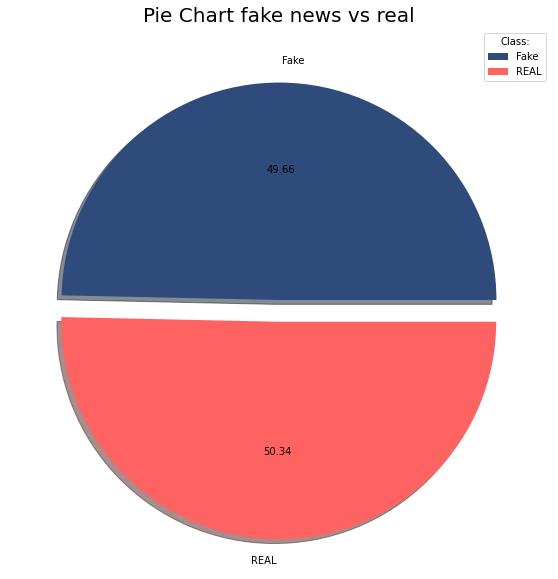

In [12]:
# Check the class imbalance:
##
## FAKE : 0
## REAL : 1
#

fake = df[df['label']==0]['label'].count()
real = df[df['label']==1]['label'].count()
print('Fake: ', fake,', REAL: ',real)

#
my_colors = ['#2f4b7c','#ff6361']   #lightblue      # 'lightsteelblue'] #, 'silver']
labels  = ['Fake','REAL']
my_explode = (0, 0.1)
plt.pie([fake,real], labels=labels,autopct='%.2f', startangle=0, shadow=True, colors=my_colors , explode=my_explode,  ) # colors='red',labeldistance=1)  # 
plt.title('Pie Chart fake news vs real', fontsize = 20)
plt.legend(title = 'Class:', loc='best' )
plt.gcf().set_size_inches((18, 10))
plt.show()

In [13]:
#  # Checking Imbalance in Data

%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# Defining all our palette colours.
primary_blue = "#496595"
primary_blue2 = "#85a1c1"
primary_grey2 = "#3f4d63"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"
primary_red = "#ff6361"

primary_green = px.colors.qualitative.Plotly[2]

In [14]:
# Now we are going to take a look about the target distribution and the messages length.

balance_counts = df.groupby('label')['label'].agg('count').values
balance_counts

array([3128, 3171])

In [15]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Fake'],
    y=[balance_counts[0]],
    name='Fake',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))
fig.add_trace(go.Bar(
    x=['Real'],
    y=[balance_counts[1]],
    name='Real',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))
fig.update_layout(
    font_family="Times New Roman",
    title = {
         'text': "Target distribution - Fake vs Real",
         'y':0.9, # new
         'x':0.5,
         'xanchor': 'center',
         'yanchor': 'top' # new
        },
    title_font_family="Times New Roman",
    font=dict(
        #family="Courier New, monospace",
        size=20)  # Set the font size here
        #color="RebeccaPurple"
    
    #title=' Target distribution by Chrun '
)
fig.show()

> ## WorldCloud

In [16]:
def create_corpus_df(review, target):
    corpus=[]

    for x in review[review['label']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

> ### Real news


In [17]:
from typing import DefaultDict

corpus_real_news = create_corpus_df(df, 1)

dic=DefaultDict(int)

for word in corpus_real_news:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('said', 15100),
 ('trump', 11012),
 ('clinton', 7679),
 ('—', 6095),
 ('people', 5700),
 ('new', 5620),
 ('president', 5177),
 ('state', 5145),
 ('campaign', 5004),
 ('republican', 4695)]

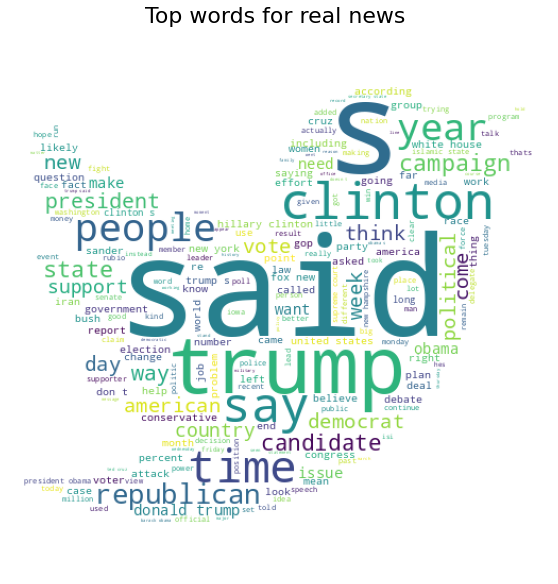

In [21]:
from PIL import Image
from wordcloud import WordCloud

twitter_mask = np.array(Image.open('/content/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 1, 'text']))
plt.figure(figsize=(18,10))
plt.title('Top words for real news ', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.gcf().set_size_inches((18, 10))
plt.show()

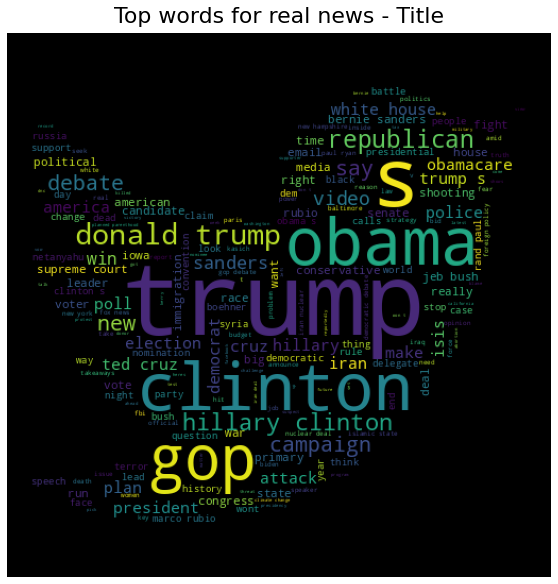

In [25]:
from PIL import Image
from wordcloud import WordCloud

twitter_mask = np.array(Image.open('/content/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='black', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 1, 'title']))
plt.figure(figsize=(18,10))
plt.title('Top words for real news - Title', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.gcf().set_size_inches((18, 10))
plt.show()

> ### Fake news


In [19]:
from typing import DefaultDict

corpus_fake_news = create_corpus_df(df, 0)

dic=DefaultDict(int)

for word in corpus_fake_news:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]
top

[('clinton', 5574),
 ('trump', 5499),
 ('people', 5040),
 ('hillary', 3997),
 ('said', 3917),
 ('just', 3524),
 ('new', 3424),
 ('–', 3295),
 ('like', 3174),
 ('election', 2855)]

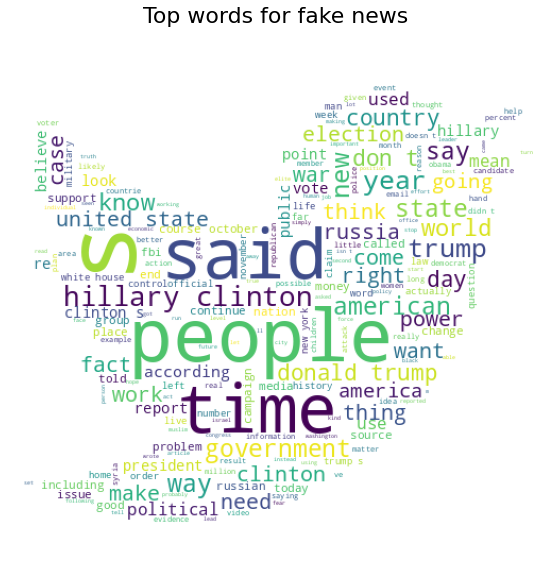

In [22]:
from PIL import Image
from wordcloud import WordCloud

twitter_mask = np.array(Image.open('/content/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 0, 'text']))
#plt.figure(figsize=(18,10))
plt.title('Top words for fake news ', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.gcf().set_size_inches((18, 10))
plt.show()

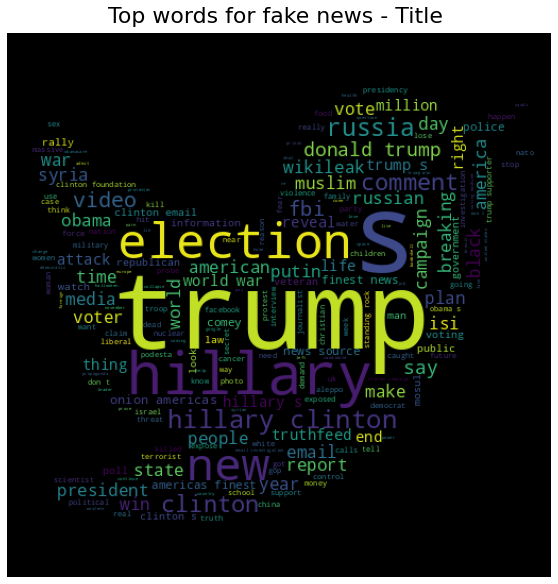

In [23]:
# For title

from PIL import Image
from wordcloud import WordCloud

twitter_mask = np.array(Image.open('/content/twitter_mask3.jpg'))

wc = WordCloud(
    background_color='black', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 0, 'title']))
#plt.figure(figsize=(18,10))
plt.title('Top words for fake news - Title ', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.gcf().set_size_inches((18, 10))
plt.show()

> # Training section

The prepared dataset will be fetched to the model for training and testing purpose.

In [35]:
# Split the dataset

X = df.drop("label",axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X.text, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)


In [26]:
y_test

3539    1
1535    0
3224    0
4566    1
3219    1
       ..
4645    1
2013    0
6210    0
3388    1
4959    1
Name: label, Length: 1260, dtype: int64

> ## XGBoost Train


In [11]:
# First of all, I will try to see if using the CountVectorizer impact the training accuracy.

# Train without the CountVector
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.pipeline import Pipeline

#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer()
#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)

In [12]:
# Fit the pipeline with the data
pipe1 = XGBClassifier()
pipe1.fit(tfidf_train, y_train)

y_pred_class = pipe1.predict(tfidf_test)
y_pred_train = pipe1.predict(tfidf_train)

print('Train Ac - without: {}'.format(accuracy_score(y_train, y_pred_train)))
print('Test Ac - without: {}'.format(accuracy_score(y_test, y_pred_class)))


Train Ac - without: 0.9972216709664616
Test Ac - without: 0.930952380952381


In [43]:
# Train with the CountVector
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer
from sklearn.pipeline import Pipeline

pipe2 = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', XGBClassifier())
                 ])

# Fit the pipeline with the data

pipe2.fit(X_train, y_train)

y_pred_class = pipe2.predict(X_test)
y_pred_train = pipe2.predict(X_train)

print('Train Ac - with: {}'.format(accuracy_score(y_train, y_pred_train)))
print('Test Ac - with: {}'.format(accuracy_score(y_test, y_pred_class)))



############


Train Ac - with: 0.9972216709664616
Test Ac - with: 0.930952380952381


In [44]:
# fit model 

pipe_xgb = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', XGBClassifier())
                 ])

pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=

In [45]:
y_pred_class = pipe_xgb.predict(X_test)
y_pred_train = pipe_xgb.predict(X_train)

print('XGB Train Accuracy: {}'.format(accuracy_score(y_train, y_pred_train)))
print('XGB Test Acuuracy: {}'.format(accuracy_score(y_test, y_pred_class)))

XGB Train Accuracy: 0.9972216709664616
XGB Test Acuuracy: 0.930952380952381


In [50]:
# make predictions 
y_pred_proba = pipe_xgb.predict_proba(X_test)
y_pred = pipe_xgb.predict(X_test)

y_test = pd.DataFrame(y_test)

y_test["predicted"] = y_pred
y_test["predicted_proba"] = y_pred_proba[:,1]

y_test.head()

,label,predicted,predicted_proba
3539,1,1,0.986671
1535,0,0,0.104295
3224,0,0,0.003206
4566,1,1,0.999809
3219,1,0,0.128714


> ## SVM Train

     

In [36]:
# fit model



X_train1, y_train1 = X_train.copy(), y_train.copy()

pipe_svm = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', SVC(probability=True))
                 ])
#svm_est =  # kernel='linear', 
pipe_svm.fit(X_train1, y_train1)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model', SVC(probability=True))])

In [37]:
X_test1, y_test1 = X_test.copy(), y_test.copy()

y_pred_class = pipe_svm.predict(X_test1)
y_pred_train = pipe_svm.predict(X_train1)

print('SVM Train Accuracy: {}'.format(accuracy_score(y_train1, y_pred_train)))
print('SVM Test Accuracy: {}'.format(accuracy_score(y_test1, y_pred_class)))


SVM Train Accuracy: 0.9986108354832308
SVM Test Accuracy: 0.942063492063492


In [38]:
# make predictions 
y_pred_proba1 = pipe_svm.predict_proba(X_test1)
y_pred1 = pipe_svm.predict(X_test1)
y_test1 = pd.DataFrame(y_test1)

y_test1["predicted"] = y_pred1
y_test1["predicted_proba"] = y_pred_proba1[:,1]
y_test1.head()

,label,predicted,predicted_proba
3539,1,1,0.999991
1535,0,0,0.031669
3224,0,0,0.004036
4566,1,1,0.995410
3219,1,1,0.835475


> ## Random Forest Train



In [39]:
# fit model 

X_train2, y_train2 = X_train.copy(), y_train.copy()

pipe_rf =  Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model',  RandomForestClassifier(max_depth=10, random_state=0))
                 ])
pipe_rf.fit(X_train2, y_train2)

Pipeline(steps=[('bow', CountVectorizer()), ('tfid', TfidfTransformer()),
                ('model',
                 RandomForestClassifier(max_depth=10, random_state=0))])

In [40]:

X_test2, y_test2 = X_test.copy(), y_test.copy()

y_pred_class = pipe_rf.predict(X_test2)
y_pred_train = pipe_rf.predict(X_train2)

print('Random Forest Train Accuracy: {}'.format(accuracy_score(y_train2, y_pred_train)))
print('Random Forest Test Acuuracy: {}'.format(accuracy_score(y_test2, y_pred_class)))

Random Forest Train Accuracy: 0.8974002778329033
Random Forest Test Acuuracy: 0.8246031746031746


In [41]:
# make predictions 
y_pred_proba = pipe_rf.predict_proba(X_test2)
y_pred = pipe_rf.predict(X_test2)

y_test2 = pd.DataFrame(y_test2)
y_test2["predicted"] = y_pred
y_test2["predicted_proba"] = y_pred_proba[:,1]
y_test2.head()
     

,label,predicted,predicted_proba
3539,1,0,0.479790
1535,0,0,0.398440
3224,0,0,0.462150
4566,1,1,0.648221
3219,1,0,0.402552


> # Evaluation section

After the model was trained and tested, we want to measure the performance of our model. Here we will plot the confusion matrix, AUC, proba disribution, and feature importance from the model.

In [46]:
# Writing a function for getting auc score for validation
scores_model = []
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

> ## XGBoost Evaluation

In [ ]:
metrics.roc_auc_score( y_test.label, y_test.predicted_proba )

0.9543453292829129

In [52]:
scores_model.append({'Model': 'XGBoost','AUC_Score': roc_auc( y_test.predicted_proba,y_test.label)}) 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


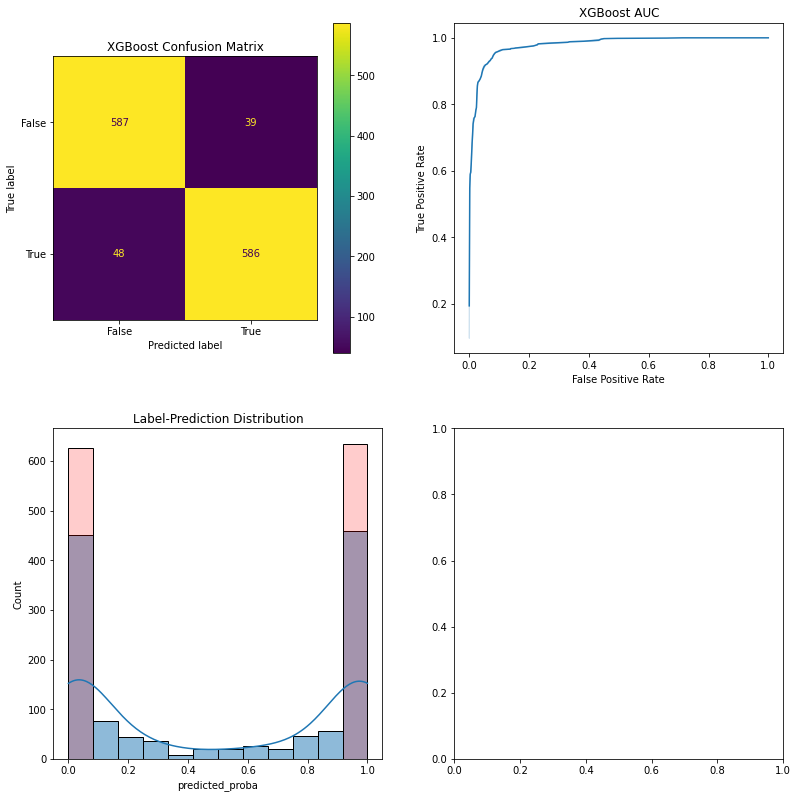

In [53]:
## ref: https://www.kaggle.com/code/irfandahusnisahid/customer-churn-prediction-using-xgboost


fig,ax = plt.subplots(2,2,figsize=(12,12))
confusion_matrix = metrics.confusion_matrix(y_test.label, y_test.predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(ax=ax[0,0])
ax[0,0].set_title("XGBoost Confusion Matrix")

fpr, tpr, _ = metrics.roc_curve(y_test.label, y_test.predicted_proba)
sns.lineplot(fpr,tpr,ax=ax[0,1])
ax[0,1].set_xlabel('False Positive Rate')
ax[0,1].set_ylabel('True Positive Rate')
ax[0,1].set_title("XGBoost AUC")

sns.histplot(y_test.predicted_proba,kde=True,ax=ax[1,0])
sns.histplot(y_test.label,kde=False,ax=ax[1,0], color="red",alpha=0.2)
ax[1,0].set_title("Label-Prediction Distribution")

#sns.barplot(data=feature_importance.iloc[0:10],x="value",y="feature",ax=ax[1,1])
#ax[1,1].set_title("Top 10 Feature Importance")

fig.tight_layout(pad=4.0)
plt.show()

In [54]:
y_test

,label,predicted,predicted_proba
3539,1,1,0.986671
1535,0,0,0.104295
3224,0,0,0.003206
4566,1,1,0.999809
3219,1,0,0.128714
...,...,...,...
4645,1,1,0.875455
2013,0,0,0.078305
6210,0,0,0.014260
3388,1,1,0.644337


In [55]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 

## If you're using the second cleaning, you can use the following command:
#xgb_predictions = xgb_est.predict(tvec.transform(X_test_cleaned))   

## Otherwise, use these commands:
xgb_preds = pipe_xgb.predict(X_test)

report = metrics.classification_report(y_test.label,xgb_preds, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("blue", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.920000,0.940000,0.930000,626.000000
1,0.940000,0.920000,0.930000,634.000000
accuracy,0.930000,0.930000,0.930000,0.930000
macro avg,0.930000,0.930000,0.930000,1260.000000
weighted avg,0.930000,0.930000,0.930000,1260.000000


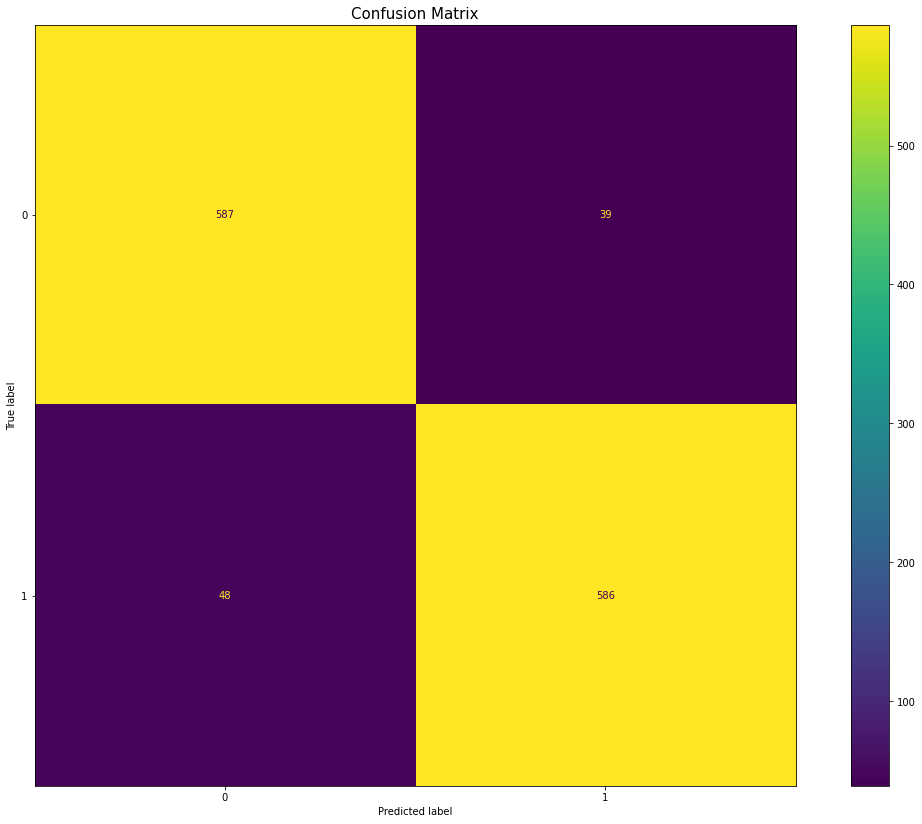

In [56]:
# First type of Confusion matrix

cm = metrics.confusion_matrix(y_test.label, xgb_preds, labels=pipe_xgb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=pipe_xgb.classes_ ) #cmap='RdBu_r'

disp.plot()
plt.title('Confusion Matrix',  fontsize = 15)
plt.gcf().set_size_inches((20, 14))
plt.show()

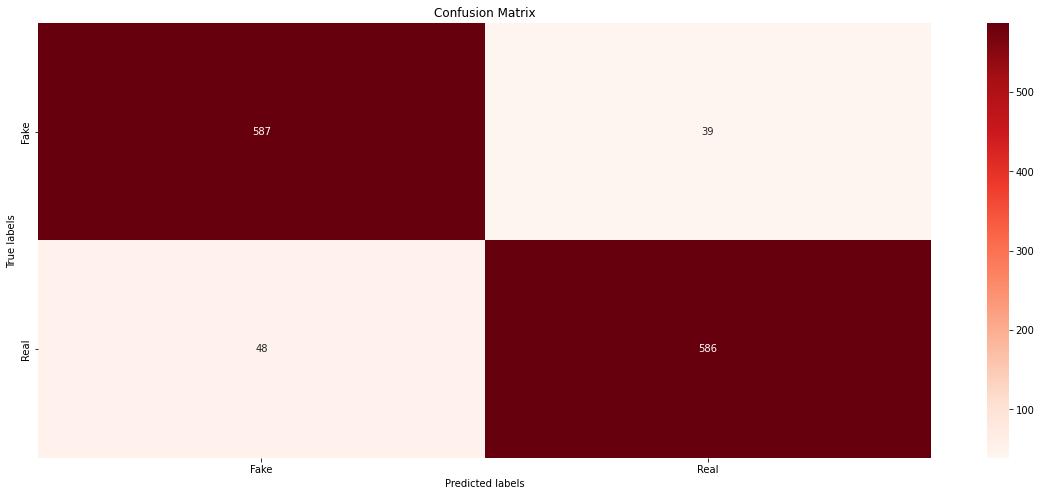

In [57]:
# Second type of confusion matrix

ax= plt.subplot()
cm= metrics.confusion_matrix(y_test.label,xgb_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);
plt.gcf().set_size_inches((20, 8))
plt.show()

In [58]:
import plotly.figure_factory as ff

x_axes = ['Fake', 'Real'] 
y_axes =  ['Real', 'Fake']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [59]:
# Third type of confusion Matrix

conf_matrix(metrics.confusion_matrix(y_test.label, xgb_preds))


In [ ]:
'''
For CM:

supported values are:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 
'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 
'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 
'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r',
'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magm..





'''

> #### Save the XGB model 

In [60]:
import pickle 


filename = "xgb_est_fake.sav"

# Save the trained model as a pickle string.
pickle.dump(pipe_xgb,open(filename, "wb") )

## Load the pickled model
xgb_from_pickle = pickle.load(open(filename, "rb"))


# Use the loaded pickled model to make predictions
print("*************  The model results:  ***********\n", xgb_from_pickle.predict(X_test))




*************  The model results:  ***********
 [1 0 0 ... 0 1 1]


> ## SVM evaluation

In [ ]:
metrics.roc_auc_score( y_test1.label, y_test1.predicted_proba )

0.8992628590772888

In [61]:
scores_model.append({'Model': 'SVM','AUC_Score': roc_auc( y_test1.predicted_proba,y_test1.label)}) 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



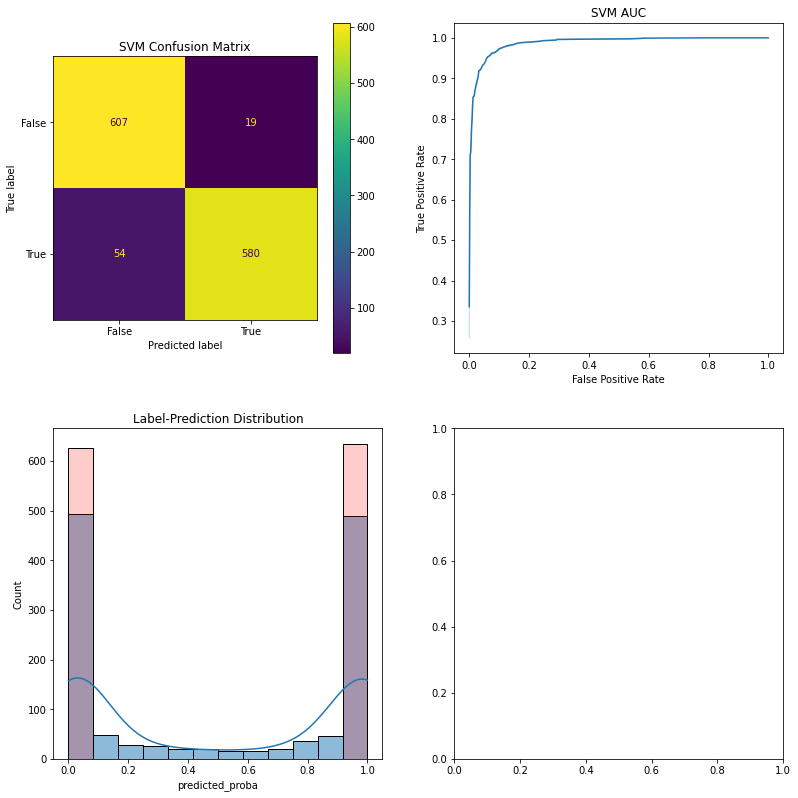

In [62]:
## ref: https://www.kaggle.com/code/irfandahusnisahid/customer-churn-prediction-using-xgboost


fig,ax = plt.subplots(2,2,figsize=(12,12))
confusion_matrix = metrics.confusion_matrix(y_test1.label, y_test1.predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(ax=ax[0,0])
ax[0,0].set_title("SVM Confusion Matrix")

fpr, tpr, _ = metrics.roc_curve(y_test1.label, y_test1.predicted_proba)
sns.lineplot(fpr,tpr,ax=ax[0,1])
ax[0,1].set_xlabel('False Positive Rate')
ax[0,1].set_ylabel('True Positive Rate')
ax[0,1].set_title("SVM AUC")

sns.histplot(y_test1.predicted_proba,kde=True,ax=ax[1,0])
sns.histplot(y_test1.label,kde=False,ax=ax[1,0], color="red",alpha=0.2)
ax[1,0].set_title("Label-Prediction Distribution")

#sns.barplot(data=permutation_importance.iloc[0:5],x="value",y="feature",ax=ax[1,1])
#ax[1,1].set_title("Top 10 Permutation Importance")

fig.tight_layout(pad=4.0)
plt.show()

In [63]:
y_test1

,label,predicted,predicted_proba
3539,1,1,0.999991
1535,0,0,0.031669
3224,0,0,0.004036
4566,1,1,0.995410
3219,1,1,0.835475
...,...,...,...
4645,1,0,0.493148
2013,0,0,0.002416
6210,0,0,0.016087
3388,1,1,0.919909


In [64]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 


## Otherwise, use these commands:
svm_preds = pipe_svm.predict(X_test1)

report = metrics.classification_report(y_test1.label,svm_preds, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("brown", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.920000,0.970000,0.940000,626.000000
1,0.970000,0.910000,0.940000,634.000000
accuracy,0.940000,0.940000,0.940000,0.940000
macro avg,0.940000,0.940000,0.940000,1260.000000
weighted avg,0.940000,0.940000,0.940000,1260.000000


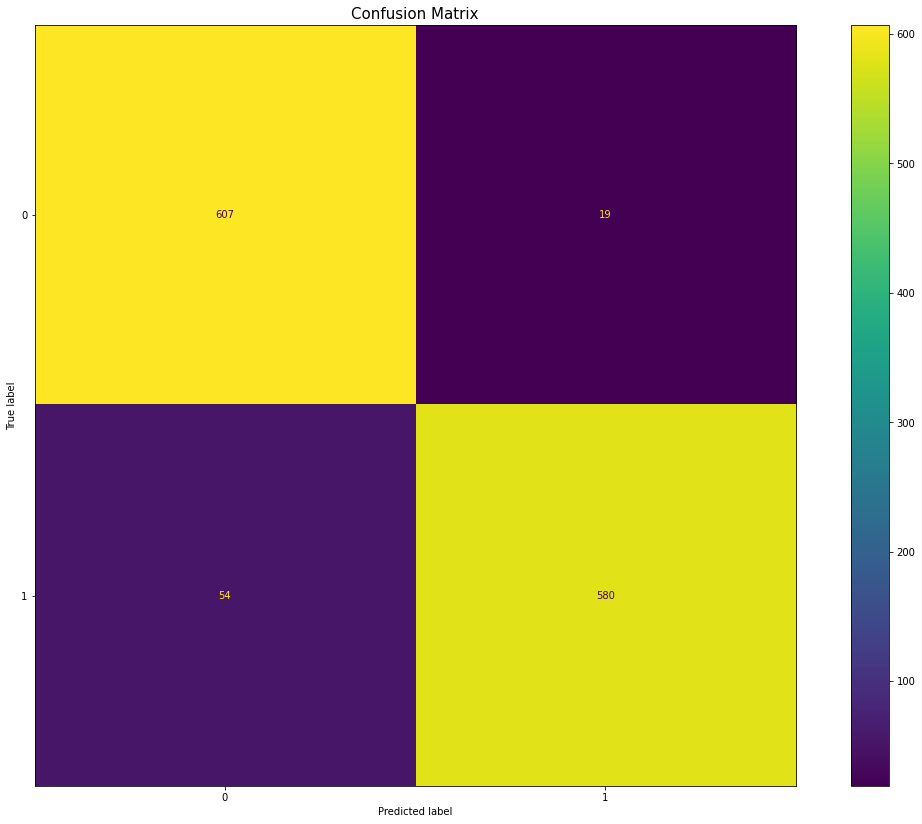

In [65]:
# First type of Confusion matrix

cm = metrics.confusion_matrix(y_test1.label, svm_preds, labels=pipe_svm.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=pipe_svm.classes_ ) #cmap='RdBu_r'

disp.plot()
plt.title('Confusion Matrix',  fontsize = 15)
plt.gcf().set_size_inches((20, 14))
plt.show()

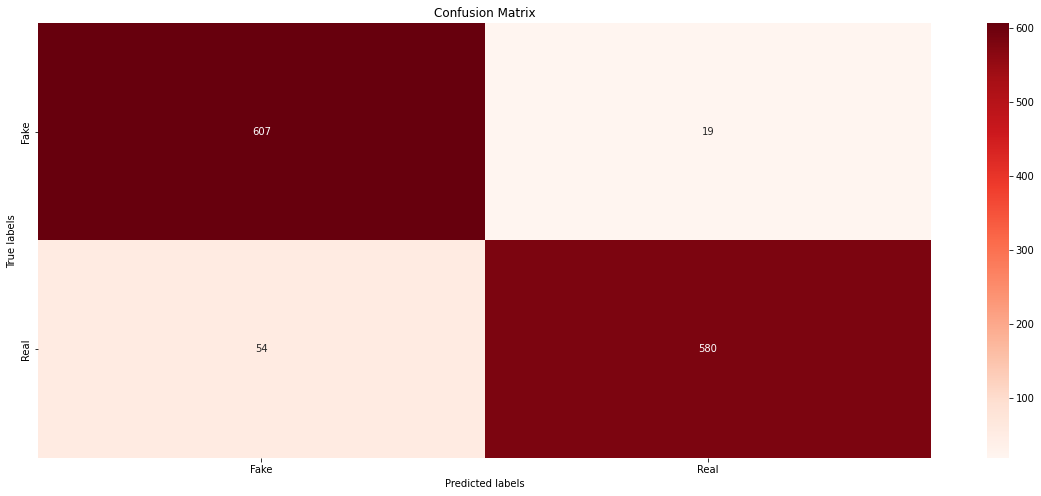

In [66]:
# Second type of confusion matrix

ax= plt.subplot()
cm= metrics.confusion_matrix(y_test1.label,svm_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);
plt.gcf().set_size_inches((20, 8))
plt.show()

In [67]:
import plotly.figure_factory as ff

x_axes = ['Fake', 'Real']
y_axes =  [ 'Real', 'Fake']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [68]:
# Third type of confusion Matrix

conf_matrix(metrics.confusion_matrix(y_test1.label, svm_preds))


In [ ]:
'''
For CM:

supported values are:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 
'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 
'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 
'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r',
'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magm..





'''

> #### Save the XGB model 

In [69]:
import pickle 


filename = "svm_est_fake.sav"

# Save the trained model as a pickle string.
pickle.dump(pipe_svm,open(filename, "wb") )

## Load the pickled model
svm_from_pickle = pickle.load(open(filename, "rb"))


# Use the loaded pickled model to make predictions
print("*************  The model results:  ***********\n", svm_from_pickle.predict(X_test))




*************  The model results:  ***********
 [1 0 0 ... 0 1 1]


> ## Random Forest evaluation

In [70]:
metrics.roc_auc_score( y_test2.label, y_test2.predicted_proba )

0.9125764707068059

In [71]:
scores_model.append({'Model': 'Random Forest','AUC_Score': roc_auc( y_test2.predicted_proba,y_test2.label)}) 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



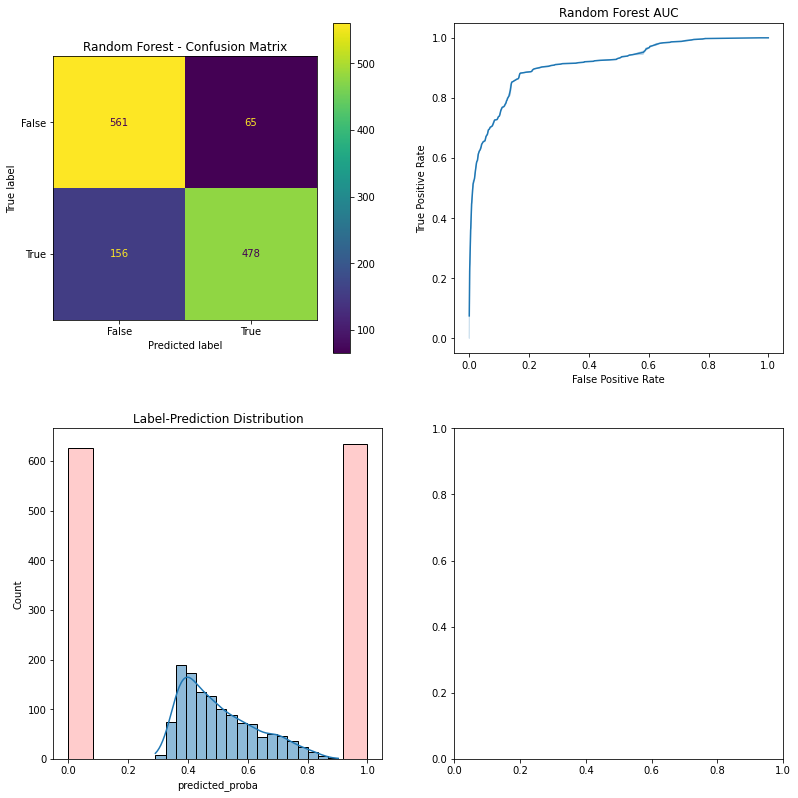

In [72]:
## ref: https://www.kaggle.com/code/irfandahusnisahid/customer-churn-prediction-using-xgboost


fig,ax = plt.subplots(2,2,figsize=(12,12))
confusion_matrix = metrics.confusion_matrix(y_test2.label, y_test2.predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(ax=ax[0,0])
ax[0,0].set_title("Random Forest - Confusion Matrix")

fpr, tpr, _ = metrics.roc_curve(y_test2.label, y_test2.predicted_proba)
sns.lineplot(fpr,tpr,ax=ax[0,1])
ax[0,1].set_xlabel('False Positive Rate')
ax[0,1].set_ylabel('True Positive Rate')
ax[0,1].set_title("Random Forest AUC")

sns.histplot(y_test2.predicted_proba,kde=True,ax=ax[1,0])
sns.histplot(y_test2.label,kde=False,ax=ax[1,0], color="red",alpha=0.2)
ax[1,0].set_title("Label-Prediction Distribution")

#sns.barplot(data=feature_importance.iloc[0:10],x="value",y="feature",ax=ax[1,1])
#ax[1,1].set_title("Top 10 Feature Importance")

fig.tight_layout(pad=4.0)
plt.show()

In [73]:
y_test2

,label,predicted,predicted_proba
3539,1,0,0.479790
1535,0,0,0.398440
3224,0,0,0.462150
4566,1,1,0.648221
3219,1,0,0.402552
...,...,...,...
4645,1,0,0.395806
2013,0,0,0.447712
6210,0,0,0.398601
3388,1,1,0.659425


In [74]:
# Predict using training and testing data and display the accuracy, f-1 score, precision for Positive and Negative Sentiment Classifiers 

## If you're using the second cleaning, you can use the following command:
#xgb_predictions = xgb_est.predict(tvec.transform(X_test_cleaned))   

## Otherwise, use these commands:
rf_preds = pipe_rf.predict(X_test2)

report = metrics.classification_report(y_test2.label,rf_preds, output_dict=True)
data_report = pd.DataFrame(report).transpose().round(2)
cm = sns.light_palette("red", as_cmap=True)
data_report.style.background_gradient(cmap=cm)

,precision,recall,f1-score,support
0,0.780000,0.900000,0.840000,626.000000
1,0.880000,0.750000,0.810000,634.000000
accuracy,0.820000,0.820000,0.820000,0.820000
macro avg,0.830000,0.830000,0.820000,1260.000000
weighted avg,0.830000,0.820000,0.820000,1260.000000


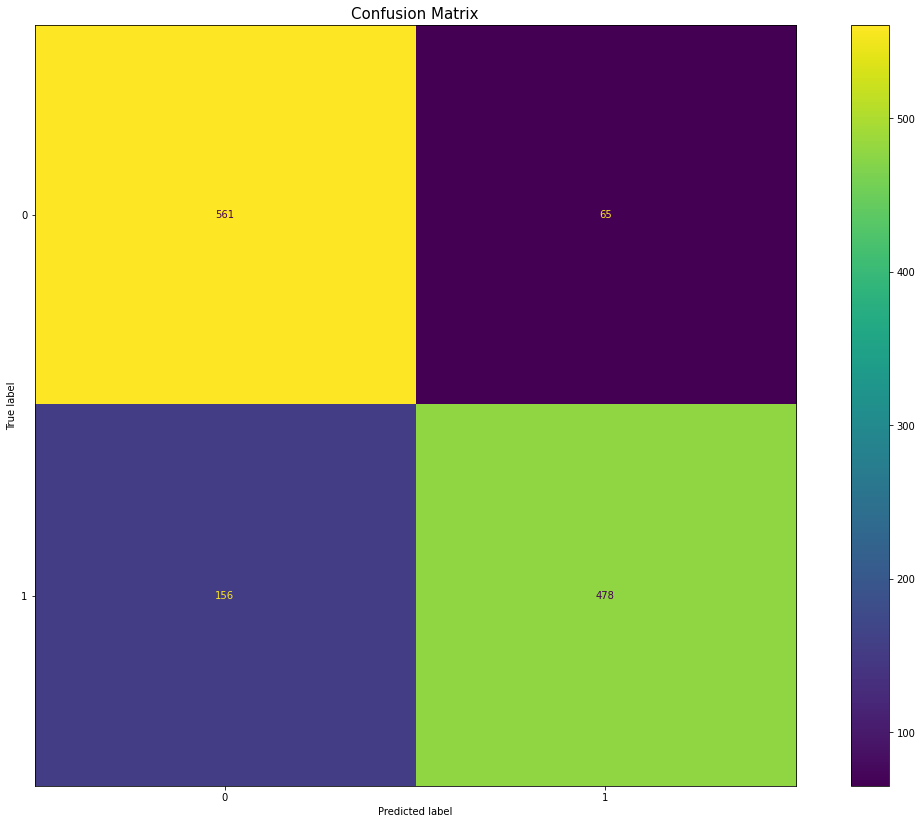

In [75]:
# First type of Confusion matrix

cm = metrics.confusion_matrix(y_test2.label, rf_preds, labels=pipe_rf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=pipe_rf.classes_ ) #cmap='RdBu_r'

disp.plot()
plt.title('Confusion Matrix',  fontsize = 15)
plt.gcf().set_size_inches((20, 14))
plt.show()

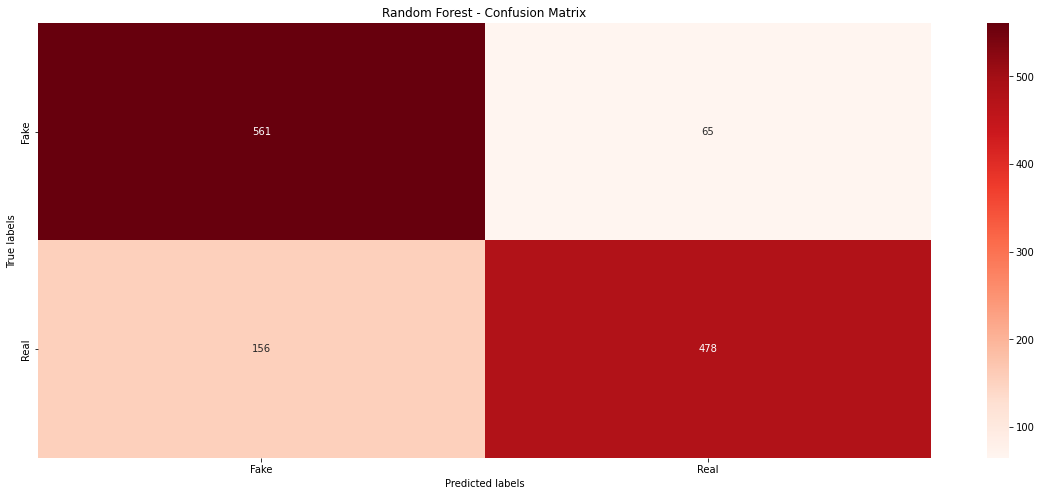

In [76]:
# Second type of confusion matrix

ax= plt.subplot()
cm= metrics.confusion_matrix(y_test2.label,rf_preds)
sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Reds');  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Random Forest - Confusion Matrix');
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);
plt.gcf().set_size_inches((20, 8))
plt.show()

In [78]:
# Third type of confusion Matrix

conf_matrix(metrics.confusion_matrix(y_test2.label, rf_preds))


In [ ]:
'''
For CM:

supported values are:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 
'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 
'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 
'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 
'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 
'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 
'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 
'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 
'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 
'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 
'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 
'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 
'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r',
'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magm..





'''

> #### Save the XGB model 

In [79]:
import pickle 


filename = "rf_est_fake.sav"

# Save the trained model as a pickle string.
pickle.dump(pipe_rf,open(filename, "wb") )

## Load the pickled model
rf_from_pickle = pickle.load(open(filename, "rb"))


# Use the loaded pickled model to make predictions
print("*************  The model results:  ***********\n", rf_from_pickle.predict(X_test))




*************  The model results:  ***********
 [0 0 0 ... 0 1 1]


> ## Results

In [80]:
# Visualization of Results obtained from various machine models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score
1,SVM,0.987619
0,XGBoost,0.979505
2,Random Forest,0.912576


> ## Comparaison:

For comparaison reasons, I used the results found in this [notebook](https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/) and compare it with mine. 

> For more information, check this [link](https://medium.com/@pamelafful56014/fake-news-classification-using-passive-aggressive-classifier-and-lime-e1360debf86c).

In [102]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer()
#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(X_train) 
tfidf_test=tfidf_vectorizer.transform(X_test)

In [103]:
from sklearn.linear_model import PassiveAggressiveClassifier

#DataFlair - Initialize a PassiveAggressiveClassifier

pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
#DataFlair - Predict on the test set and calculate accuracy
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test.label,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 94.6%


In [104]:
# make predictions 
y_pred_proba = pac.decision_function(tfidf_test)
y_pred = pac.predict(tfidf_test)

y_test_c = pd.DataFrame(y_test.label)
y_test_c["predicted"] = y_pred
y_test_c["predicted_proba"] = y_pred_proba
y_test_c.head()
     

,label,predicted,predicted_proba
3539,1,1,1.309084
1535,0,0,-0.862922
3224,0,0,-1.913429
4566,1,1,1.463747
3219,1,1,0.630868


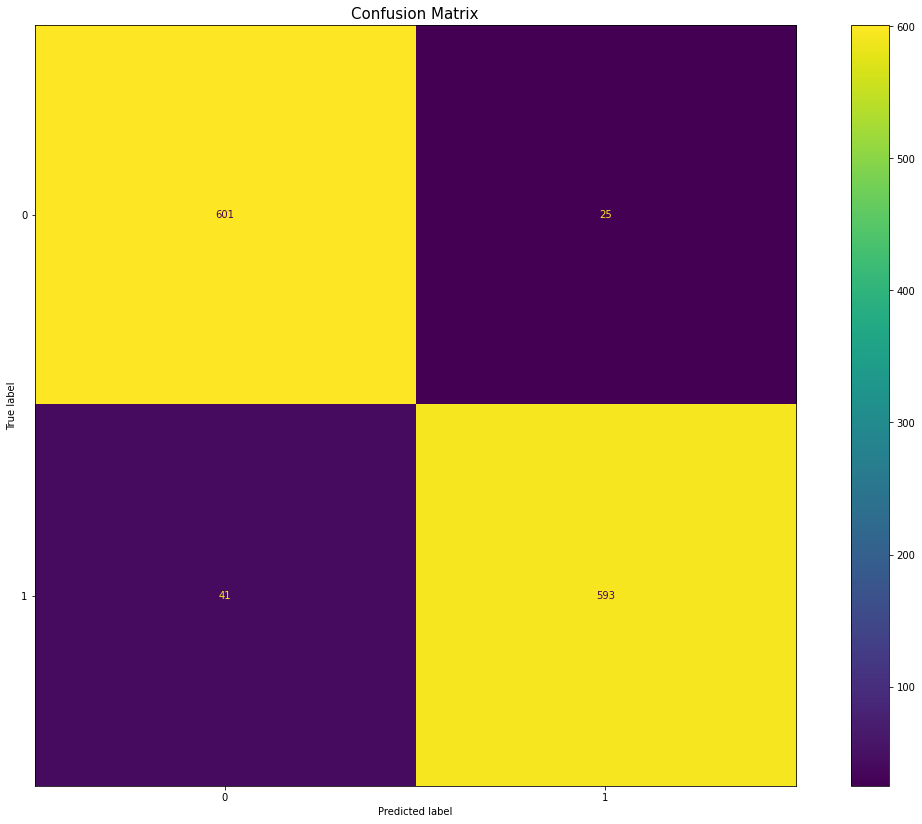

In [98]:
#DataFlair - Build confusion matrix
# First type of Confusion matrix

cm = metrics.confusion_matrix(y_test_c.label, y_pred, labels=pac.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=pac.classes_ ) #cmap='RdBu_r'

disp.plot()
plt.title('Confusion Matrix',  fontsize = 15)
plt.gcf().set_size_inches((20, 14))
plt.show()

In [105]:
scores_model.append({'Model': 'PassiveAggressiveClassifier2','AUC_Score': roc_auc( y_test_c.predicted_proba,y_test_c.label)}) 

In [106]:
# Visualization of Results obtained from various machine models
f_results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
f_results.style.background_gradient(cmap='gray')

,Model,AUC_Score
3,PassiveAggressiveClassifier,0.988279
4,PassiveAggressiveClassifier2,0.987916
1,SVM,0.987619
0,XGBoost,0.979505
2,Random Forest,0.912576
